In [ ]:
import getpass
import os
from langchain_community.document_loaders import TextLoader, DirectoryLoader, UnstructuredMarkdownLoader
from langchain_community.vectorstores import Chroma
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from pathlib import Path
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

# _set_env("DEEPSEEK_API_KEY ")

import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "default"

In [2]:


# ✅ 方式1: 读取单个 Markdown 文件
def load_single_markdown(file_path: str):
    """加载单个 Markdown 文件"""
    loader = UnstructuredMarkdownLoader(file_path)
    docs = loader.load()
    return docs

# ✅ 方式2: 读取多个 Markdown 文件
def load_multiple_markdowns(file_paths: list):
    """加载多个 Markdown 文件"""
    docs_list = []
    for file_path in file_paths:
        try:
            loader = UnstructuredMarkdownLoader(file_path)
            docs = loader.load()
            docs_list.extend(docs)
            print(f"✅ 成功加载: {file_path}")
        except Exception as e:
            print(f"❌ 加载失败 {file_path}: {e}")
    return docs_list

# ✅ 方式3: 读取整个目录下的所有 Markdown 文件
def load_markdown_directory(directory_path: str):
    """加载目录下所有 Markdown 文件"""
    loader = DirectoryLoader(
        directory_path,
        glob="**/*.md",  # 匹配所有 .md 文件
        loader_cls=UnstructuredMarkdownLoader,
        show_progress=True
    )
    docs = loader.load()
    return docs


In [3]:
import requests
from langchain_core.embeddings import Embeddings
from typing import List

class SiliconFlowEmbeddings(Embeddings):
    def __init__(self, model: str, api_key: str, url: str, batch_size: int = 32):
        self.model = model
        self.api_key = api_key
        self.url = url
        self.batch_size = batch_size

    def _embed_batch(self, texts: List[str]) -> List[List[float]]:
        payload = {"model": self.model, "input": texts}
        headers = {
            "Authorization": f"Bearer {self.api_key}",
            "Content-Type": "application/json"
        }
        response = requests.post(self.url, json=payload, headers=headers)
        result = response.json()
        if result.get("code") not in (None, 0):
            raise ValueError(f"Embedding request failed: {result}")
        data = result.get("data")
        if not data:
            raise ValueError(f"No embedding data returned: {result}")
        return [item["embedding"] for item in data]

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        embeddings: List[List[float]] = []
        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            embeddings.extend(self._embed_batch(batch))
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        return self.embed_documents([text])[0]

In [4]:
from random import randint

docs = load_single_markdown('C:\\Users\\12153\\Desktop\\首饰雕蜡工艺-全本.txt')
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=200,
        separators=["\n\n", "\n", " ", ""]
    )
split_docs = text_splitter.split_documents(docs)

print(f"加载的split_docs数量: {len(split_docs)}")
random_index = randint(0, len(split_docs)-1)
print(f"随机选择的文档索引: {random_index}")
print(f"示例文档内容: {split_docs[random_index].page_content[:500]}")  # 打印前500个字符作为示例

加载的split_docs数量: 219
随机选择的文档索引: 137
示例文档内容: 锯切掉蝴蝶蜡件底部的“把手”，为安装可佩戴结构部件做好准备，如图所示。根据需求为蝴蝶蜡件熔焊首饰佩戴结构，如图所示。首饰中可佩戴结构部件的具体制作方法可以参见第8章的内容。 完成3种不同表面图案的蝴蝶造型的制作，如图所示。 立体镂空造型的雕蜡方法 $\diamond$ 立体镂空造型的定位与锯切 制作立体镂空造型比较考验对蜡件造型的预判能力，但准确的图纸和规范的雕蜡方法会降低制作难度。本节将以一条弯曲扭转的小蛇作为案例，让读者比较轻松地掌握立体镂空造型的定位与锯切方法。 步骤01 准备好尺寸为1:1的图纸。在这个案例中，需要分别准备两个面的图纸，如图所示。在准备立体造型的图纸时，两个面的图纸是尺寸一致且造型准确的，需要考虑到正面造型和背面造型的前后关系和连接。比如在这个案例中，需要提前想好小蛇盘旋扭转的造型路径。想让图案准确且合理，可以在绘制图纸前用橡皮泥之类的可塑性材料快速进行造型模拟捏制，以便作为参考。 步骤02 根据图纸准备尺寸合适的蜡块，如图所示。准备蜡块时，不光要考虑宽度和长度，整体造型的厚度也要考虑到。 步骤03


In [ ]:
from langchain_community.vectorstores import Chroma

chroma_db_dir = 'chroma_db'
embeddings = SiliconFlowEmbeddings(
    model="BAAI/bge-large-zh-v1.5",
    api_key="sk-0511c57af3604877b63cf32ea9ae7f01",  # 替换为你的真实 token
    url="https://api.siliconflow.cn/v1/embeddings"
)

if os.path.exists(chroma_db_dir) and os.listdir(chroma_db_dir):
    print('✅ 发现已存在的 Chroma 数据库，正在加载...')
    # 加载已有的 Chroma 向量数据库

    vectorstore = Chroma(
        collection_name="rag_local_markdown_docs",
        embedding_function=embeddings,
        persist_directory="./chroma_db"
    )
    
    print('✅ 已有向量数据库加载成功！')
else:
    print('⚠️ 未发现已有的 Chroma 数据库，正在创建新的数据库...')
    # 创建新的 Chroma 向量数据库
    # 选择加载方式
    docs = load_single_markdown('C:\\Users\\12153\\Desktop\\首饰雕蜡工艺-全本.txt')
    # docs = load_multiple_markdowns(['path/to/your/file1.md', 'path/to/your/file2.md'])
    # docs = load_single_markdown(chroma_db_dir)

    # 文本拆分
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=200,
        separators=["\n\n", "\n", " ", ""]
    )
    split_docs = text_splitter.split_documents(docs)
    print(f'✅ 文本拆分完成，生成 {len(split_docs)} 个文档块。')
    # 创建向量数据库
 
    vectorstore = Chroma.from_documents(
        documents=split_docs,
        embedding=embeddings,
        collection_name="rag_local_markdown_docs",
        persist_directory="./chroma_db"
    )
    vectorstore.persist()
    print('✅ 新的向量数据库创建并保存成功！')
retrieve_jewelry_wax_craft = vectorstore.as_retriever()

✅ 发现已存在的 Chroma 数据库，正在加载...


C:\Users\12153\AppData\Local\Temp\ipykernel_27384\1445560232.py:14: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


✅ 已有向量数据库加载成功！


Then we create a retriever tool.

In [6]:
from langchain_core.tools import create_retriever_tool
retrieve_jewelry_wax_craft_tool = create_retriever_tool(
    retrieve_jewelry_wax_craft,
    # 工具名称
    name="retrieve_jewelry_wax_craft",
    # 工具描述 作用: 告诉代理何时以及如何使用此工具
    description="""搜索并返回关于首饰雕蜡工艺相关信息。"""
)


tools = [retrieve_jewelry_wax_craft_tool]

## Agent State

In [7]:
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Nodes and Edges

In [ ]:
from typing import Annotated, Literal, Sequence, TypedDict


from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import List, Optional, Literal
from langchain_deepseek import ChatDeepSeek
from langchain_openai import ChatOpenAI


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(base_url = "https://api.siliconflow.cn/v1", 
                       api_key=os.environ['DEEPSEEK_API_KEY'], 
                       model="deepseek-ai/DeepSeek-V3.1-Terminus", temperature=0, streaming=True
                       )

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
    template="""你是一个文档相关性评估员，负责评估检索到的文档与用户问题的相关性。\n 
        以下是检索到的文档： \n\n {context} \n\n
        以下是用户问题： {question} \n
        如果文档包含与用户问题相关的关键词或语义内容，则评为相关。\n
        请给出二元评分 'yes' 或 'no' 来表示文档是否与问题相关。""",
            input_variables=["context", "question"],
        )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    print("Current messages to agent:")
    print(messages)
    system_prompt = (
        "你是智能助理。凡与首饰雕蜡或相关铸造工艺的问题，使用工具 retrieve_jewelry_wax_craft；"
        "其他通用问题请直接回答，不要调用任何工具。先判断问题类型再决定是否调用工具。"
    )
    
    # 添加系统提示第二版本，指导 agent 何时使用工具
    system_message2 = """你是一个智能助手。当用户询问关于首饰雕蜡工艺的问题时，使用 retrieve_livermore_biography 工具来检索相关信息。
对于其他一般性问题（如数学、常识、定义等），请直接回答，无需使用工具。

判断标准：
- 如果问题涉及首饰雕蜡工艺的历史、材料、工具、制作步骤或设计技巧，使用检索工具
- 如果问题是通用知识（如贝叶斯定理、数学问题、常识等），直接回答"""

    messages_with_system = [SystemMessage(content=system_prompt)] + list(messages)
    model = ChatOpenAI(base_url = "https://api.siliconflow.cn/v1", 
                       api_key=os.environ['DEEPSEEK_API_KEY'], 
                       model="deepseek-ai/DeepSeek-V3.1-Terminus", temperature=0, streaming=True
                       )
    model = model.bind_tools(tools)
    response = model.invoke(messages_with_system)
    print("---AGENT RESPONSE start---")
    print(response)
    print("---AGENT RESPONSE COMPLETE---")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

def agent2(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    
    # 添加系统提示，指导 agent 何时使用工具
    system_message = """你是一个智能助手。当用户询问关于首饰雕蜡工艺的问题时，使用 retrieve_livermore_biography 工具来检索相关信息。
对于其他一般性问题（如数学、常识、定义等），请直接回答，无需使用工具。

判断标准：
- 如果问题涉及首饰雕蜡工艺的历史、材料、工具、制作步骤或设计技巧，使用检索工具
- 如果问题是通用知识（如贝叶斯定理、数学问题、常识等），直接回答"""
    
    # 将系统消息添加到消息列表开头
    from langchain_core.messages import SystemMessage
    messages_with_system = [SystemMessage(content=system_message)] + messages
    
    model = ChatOpenAI(base_url = "https://api.siliconflow.cn/v1", 
                       api_key=os.environ['DEEPSEEK_API_KEY'], 
                       model="deepseek-ai/DeepSeek-V3.1-Terminus", temperature=0, streaming=True
                       )
    model = model.bind_tools(tools)
    response = model.invoke(messages_with_system)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    查看输入并尝试分析其底层的语义意图/含义。 \n 
    这是初始问题：
    \n ------- \n
    {question} 
    \n ------- \n
    请提出一个改进的问题： """,
        )
    ]

    # Grader
    # model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    model = ChatOpenAI(base_url = "https://api.siliconflow.cn/v1", 
                       api_key=os.environ['DEEPSEEK_API_KEY'], 
                       model="deepseek-ai/DeepSeek-V3.1-Terminus", temperature=0, streaming=True
                       )
    response = model.invoke(msg)
    return {"messages": [response]}


from langchain_core.prompts import ChatPromptTemplate

def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content
    print(f"Docs for generation: {docs}")
    # Prompt
    prompt = ChatPromptTemplate.from_template(
    """你是一个专业的问答助手。请根据以下检索到的上下文内容来回答问题。如果你不知道答案，请直接说不知道。请保持回答简洁，最多使用三句话。
问题：{question} 
上下文：{context} 
回答："""
)

    llm = ChatOpenAI(base_url = "https://api.siliconflow.cn/v1", 
                       api_key=os.environ['DEEPSEEK_API_KEY'], 
                       model="deepseek-ai/DeepSeek-V3.1-Terminus", temperature=0, streaming=True
                       )
    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    print("---GENERATED RESPONSE start---")
    print(response)
    print("---GENERATED RESPONSE COMPLETE---")
    return {"messages": [response]}


## Graph

In [9]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `retrieve` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    {
        "generate": "generate",  # 文档相关 -> 生成答案
        "rewrite": "rewrite"     # 文档不相关 -> 重写查询
    }
)

# 生成答案后结束
workflow.add_edge("generate", END)

# 重写后回到 agent
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

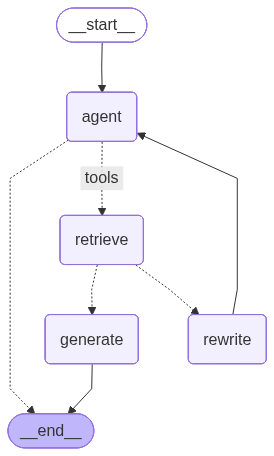

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
import pprint

inputs = {
    "messages": [
        ("user", "雕蜡与铸造工艺基本原理"),
    ]
}
 
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


d:\ai_works\langgraph\.venv\Lib\site-packages\pydantic\v1\main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


---CALL AGENT---
Current messages to agent:
[HumanMessage(content='雕蜡与铸造工艺基本原理', additional_kwargs={}, response_metadata={}, id='429eab6b-67c4-44d5-a69f-f4a64923aa5d')]
---AGENT RESPONSE start---
content='我来为您搜索关于雕蜡与铸造工艺基本原理的相关信息。' additional_kwargs={} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'deepseek-ai/DeepSeek-V3.1-Terminus', 'model_provider': 'openai'} id='lc_run--8d412019-8b2c-4264-87b6-7b31d9c3ba12' tool_calls=[{'name': 'retrieve_jewelry_wax_craft', 'args': {'query': '雕蜡与铸造工艺基本原理'}, 'id': '019acd853d5554919b6b9faf067dc63c', 'type': 'tool_call'}] usage_metadata={'input_tokens': 13334, 'output_tokens': 2207, 'total_tokens': 15541, 'input_token_details': {}, 'output_token_details': {}}
---AGENT RESPONSE COMPLETE---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='我来为您搜索关于雕蜡与铸造工艺基本原理的相关信息。', additional_kwargs={}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'deepseek-ai/DeepSeek-V3.1-Terminus', 'model_provider': 'openai'}

In [12]:
 
inputs2 = {
    "messages": [
        ("user", "解释贝叶斯定理"),
    ]
}

for output in graph.stream(inputs2):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
Current messages to agent:
[HumanMessage(content='解释贝叶斯定理', additional_kwargs={}, response_metadata={}, id='447f3d43-57ff-4dcf-a30b-4f7dde2ffa75')]
---AGENT RESPONSE start---
content='贝叶斯定理是概率论中的一个重要定理，它描述了在已知先验概率的情况下，如何根据新的证据来更新我们对事件发生概率的信念。\n\n## 贝叶斯定理的公式\n\n贝叶斯定理的数学表达式为：\n\n\\[ P(A|B) = \\frac{P(B|A) \\cdot P(A)}{P(B)} \\]\n\n其中：\n- **P(A|B)** 是后验概率：在事件B发生的条件下，事件A发生的概率\n- **P(B|A)** 是似然概率：在事件A发生的条件下，事件B发生的概率\n- **P(A)** 是先验概率：事件A发生的初始概率（在获得新证据之前）\n- **P(B)** 是证据概率：事件B发生的总概率\n\n## 直观理解\n\n贝叶斯定理的核心思想是：**用新的证据来修正我们原有的信念**。\n\n举个例子：\n- 假设某种疾病的患病率是1%（先验概率P(A)）\n- 检测的准确率：如果患病，检测结果为阳性的概率是99%（似然概率P(B|A)）\n- 如果检测结果为阳性，那么实际患病的概率是多少？（后验概率P(A|B)）\n\n通过贝叶斯定理计算，结果可能远低于99%，因为要考虑疾病的低患病率这个先验信息。\n\n## 应用领域\n\n贝叶斯定理广泛应用于：\n- 机器学习（贝叶斯分类器）\n- 医学诊断\n- 垃圾邮件过滤\n- 金融风险评估\n- 人工智能推理系统\n\n贝叶斯定理提供了一种系统性的方法来处理不确定性和更新信念，是现代概率论和统计学的重要基础。' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'deepseek-ai/DeepSeek-V3.1-Terminus', 'model_provider': 'openai'} id='lc_run--6464

In [13]:
inputs3 = {
    "messages": [
        ("user", "利弗莫尔活了多少岁？"),
    ]
}
output3 = graph.invoke(inputs3)
 
for key, value in output3.items():
    pprint.pprint(f"Output from node '{key}':")
    pprint.pprint("---")
    pprint.pprint(value, indent=2, width=80, depth=None)
pprint.pprint("\n---\n")

---CALL AGENT---
Current messages to agent:
[HumanMessage(content='利弗莫尔活了多少岁？', additional_kwargs={}, response_metadata={}, id='ff2084d6-ae8f-4735-86d2-468137c199cd')]
---AGENT RESPONSE start---
content='杰西·利弗莫尔（Jesse Livermore）是美国著名的股票投机者，他于1877年7月26日出生，1940年11月28日去世。因此，他活了**63岁**。' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'deepseek-ai/DeepSeek-V3.1-Terminus', 'model_provider': 'openai'} id='lc_run--4217f151-d5e9-4564-b59b-a8602dbb95aa' usage_metadata={'input_tokens': 11628, 'output_tokens': 1274, 'total_tokens': 12902, 'input_token_details': {}, 'output_token_details': {}}
---AGENT RESPONSE COMPLETE---
"Output from node 'messages':"
'---'
[ HumanMessage(content='利弗莫尔活了多少岁？', additional_kwargs={}, response_metadata={}, id='ff2084d6-ae8f-4735-86d2-468137c199cd'),
  AIMessage(content='杰西·利弗莫尔（Jesse Livermore）是美国著名的股票投机者，他于1877年7月26日出生，1940年11月28日去世。因此，他活了**63岁**。', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'deep

In [14]:
output3['messages'][-1].content

'杰西·利弗莫尔（Jesse Livermore）是美国著名的股票投机者，他于1877年7月26日出生，1940年11月28日去世。因此，他活了**63岁**。'